# Arima

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Carregar o arquivo principal (dados históricos até 2023)
data = pd.read_csv(r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\Py\Analise\Forecast\Arquivos\data.csv")
data['Date mais recente'] = pd.to_datetime(data['Date mais recente'])
data.set_index('Date mais recente', inplace=True)
ts_data = data['Total']

# Definir as faixas de valores a serem testados para (p, d, q)
p = d = q = range(0, 4)  # Testar valores de 0 a 2 para cada parâmetro
pdq_combinations = list(itertools.product(p, d, q))

# Variáveis para armazenar o melhor modelo e o menor AIC
best_aic = float("inf")
best_order = None
best_model = None

# Loop para encontrar a melhor combinação de (p, d, q)
for order in pdq_combinations:
    try:
        # Ajustar o modelo ARIMA com a combinação atual
        model = ARIMA(ts_data, order=order)
        fitted_model = model.fit()
        # Verificar se o AIC do modelo atual é o menor encontrado
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_order = order
            best_model = fitted_model
    except Exception as e:
        # Ignorar combinações que causam erros
        continue

# Exibir a melhor combinação de (p, d, q) e o valor de AIC correspondente
print(f"Melhor ordem (p, d, q): {best_order}")
print(f"Menor AIC: {best_aic}")

# Opcional: Exibir o resumo do melhor modelo encontrado
print(best_model.summary())


Melhor ordem (p, d, q): (0, 3, 2)
Menor AIC: 668.1264684181264
                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   36
Model:                 ARIMA(0, 3, 2)   Log Likelihood                -331.063
Date:                Fri, 01 Nov 2024   AIC                            668.126
Time:                        13:25:02   BIC                            672.616
Sample:                    01-01-2021   HQIC                           669.637
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9974      0.381     -5.244      0.000      -2.744      -1.251
ma.L2          0.9978      0.394      2.533      0.011       0.226  

c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


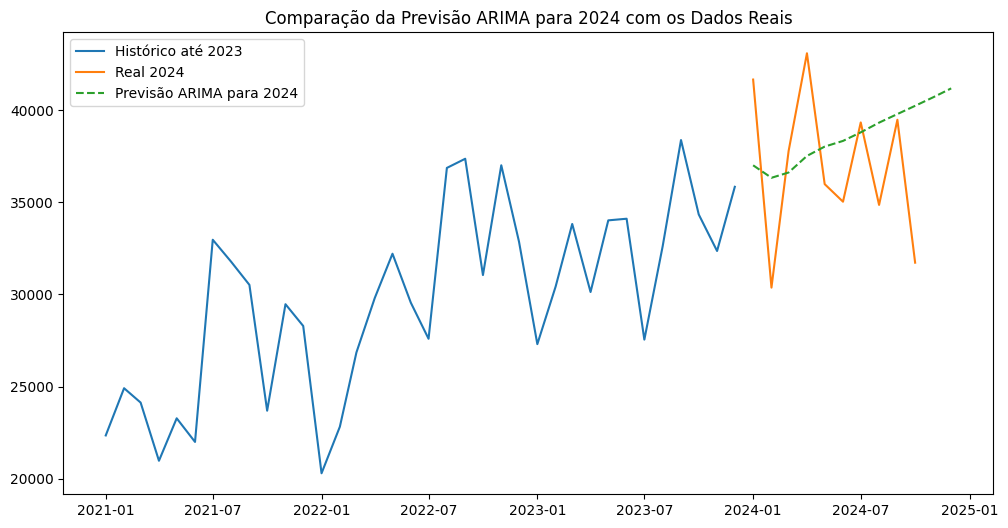

            Real 2024  Previsão ARIMA 2024
2024-01-01    41661.0         37008.525987
2024-02-01    30372.0         36331.080203
2024-03-01    37785.0         36618.955779
2024-04-01    43087.0         37517.157571
2024-05-01    35988.0         38023.229344
2024-06-01    35034.0         38332.019903
2024-07-01    39335.0         38796.803774
2024-08-01    34859.0         39323.453168
2024-09-01    39480.0         39789.128369
2024-10-01    31725.0         40236.187909
2024-11-01        NaN         40706.718536
2024-12-01        NaN         41182.517194


In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Carregar o arquivo principal (dados históricos até 2023)
data = pd.read_csv(r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\Py\Analise\Forecast\Arquivos\data.csv")
data['Date mais recente'] = pd.to_datetime(data['Date mais recente'])
data.set_index('Date mais recente', inplace=True)
ts_data = data['Total']

# Carregar o arquivo de saída para 2024 (dados reais de 2024)
data_2024 = pd.read_csv(r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\2024 saidas.csv")
data_2024['Date mais recente'] = pd.to_datetime(data_2024['Date mais recente'])
data_2024.set_index('Date mais recente', inplace=True)
ts_data_2024 = data_2024['Total']

# Ajustar o modelo ARIMA nos dados históricos até o final de 2023
model_full = ARIMA(ts_data, order=(2, 2, 1))  # Parâmetros (p, d, q) iniciais
fitted_model_full = model_full.fit()

# Fazer previsões para o ano de 2024 (12 meses à frente)
forecast_2024 = fitted_model_full.forecast(steps=12)

# Plotar os dados históricos, os dados reais de 2024 e a previsão para 2024
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Histórico até 2023')
plt.plot(ts_data_2024, label='Real 2024')
plt.plot(forecast_2024, label='Previsão ARIMA para 2024', linestyle='--')
plt.title('Comparação da Previsão ARIMA para 2024 com os Dados Reais')
plt.legend()
plt.show()


comparison_df = pd.DataFrame({
    'Real 2024': ts_data_2024,
    'Previsão ARIMA 2024': forecast_2024
})
# Exibir a tabela comparativa
print(comparison_df)


# ExponentialSmoothing

In [ ]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

monthly_data = pd.read_csv(r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\Py\Analise\Forecast\Arquivos\data.csv")

# Selecionar a série temporal mensal
monthly_series = monthly_data['Total']

# Ajustar o modelo ETS com sazonalidade anual (período sazonal de 12 meses)
model = ExponentialSmoothing(monthly_series, 
                             trend='add', 
                             seasonal='add', 
                             seasonal_periods=12)
model_fit = model.fit()

# Previsão para os próximos 12 meses
forecast = model_fit.forecast(steps=12)


# Adicionar rótulos nos pontos dos dados históricos
forecast_df = forecast.to_frame(name='Previsão_Qtd_UM_registro')

# Exibir o DataFrame de previsão
forecast_df

c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Previsão_Qtd_UM_registro
36,27331.182136
37,30613.224297
38,34498.335344
39,34100.460089
40,37322.351139
41,36178.803344
42,37916.004118
43,42095.808765
44,41756.422821
45,35154.338146


In [52]:
monthly_data.head

<bound method NDFrame.head of      Ano        Mês  Total    Date mais recente
0   2021    janeiro  22352  2021-01-01 00:00:00
1   2021  fevereiro  24914  2021-02-01 00:00:00
2   2021      março  24135  2021-03-01 00:00:00
3   2021      abril  20978  2021-04-01 00:00:00
4   2021       maio  23282  2021-05-01 00:00:00
5   2021      junho  22000  2021-06-01 00:00:00
6   2021      julho  32970  2021-07-01 00:00:00
7   2021     agosto  31780  2021-08-01 00:00:00
8   2021   setembro  30521  2021-09-01 00:00:00
9   2021    outubro  23695  2021-10-01 00:00:00
10  2021   novembro  29472  2021-11-01 00:00:00
11  2021   dezembro  28291  2021-12-01 00:00:00
12  2022    janeiro  20299  2022-01-01 00:00:00
13  2022  fevereiro  22827  2022-02-01 00:00:00
14  2022      março  26855  2022-03-01 00:00:00
15  2022      abril  29807  2022-04-01 00:00:00
16  2022       maio  32211  2022-05-01 00:00:00
17  2022      junho  29555  2022-06-01 00:00:00
18  2022      julho  27597  2022-07-01 00:00:00
19  2022  

# LSTM

c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


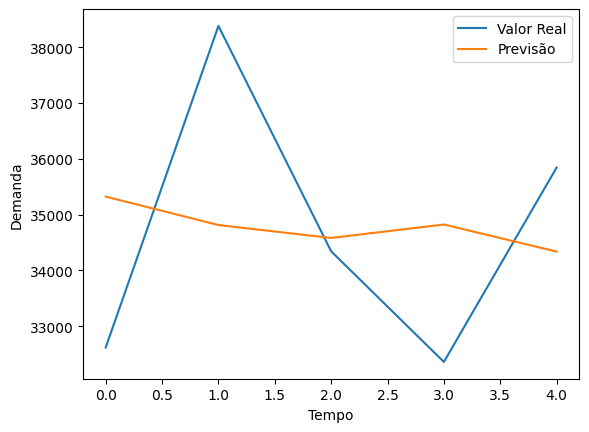

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\fsp_adolpho.salvador\AppData\Local\Temp\ipykernel_19628\4265637009.py:83: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_2024 = pd.date_range(start='2024-01-01', periods=n_months, freq='M')


,Data,Previsão de Demanda
0,2024-01-31,"34.541,52"
1,2024-02-29,"35.185,53"
2,2024-03-31,"35.622,53"
3,2024-04-30,"35.779,22"
4,2024-05-31,"36.305,32"
5,2024-06-30,"36.474,57"
6,2024-07-31,"36.689,71"
7,2024-08-31,"37.612,05"
8,2024-09-30,"38.030,67"
9,2024-10-31,"37.892,65"


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Carregar e pré-processar os dados
def load_and_preprocess_data(file_path, seq_length):
    data = pd.read_csv(file_path)
    data_values = data[['Total']].values  # Supondo que a coluna a ser usada é 'Total'
    
    # Normalizar os dados
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_values)
    
    # Função para criar sequência de dados para o modelo LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(data_scaled, seq_length)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler, data_scaled

# Construir o modelo LSTM
def build_lstm_model(seq_length):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Treinar o modelo com Early Stopping
def train_model(model, X_train, y_train, X_test, y_test):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
                        callbacks=[early_stopping], batch_size=16, verbose=0)
    return history

# Avaliação e visualização dos resultados
def evaluate_and_plot(model, X_test, y_test, scaler):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_original = scaler.inverse_transform(y_test)
    
    plt.plot(y_test_original, label='Valor Real')
    plt.plot(y_pred, label='Previsão')
    plt.xlabel('Tempo')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()
    
    # Formatar resultados no padrão brasileiro
    results = pd.DataFrame({
        'Valor Real': [f"{val[0]:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") for val in y_test_original],
        'Previsão': [f"{val[0]:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") for val in y_pred]
    })
    return results

# Função para previsão de meses futuros
def forecast_future(model, scaler, data_scaled, seq_length, n_months):
    last_sequence = data_scaled[-seq_length:]
    predictions = []
    
    for _ in range(n_months):
        last_sequence_reshaped = last_sequence.reshape((1, seq_length, 1))
        next_pred_scaled = model.predict(last_sequence_reshaped)
        next_pred = scaler.inverse_transform(next_pred_scaled)
        predictions.append(next_pred[0, 0])
        last_sequence = np.append(last_sequence, next_pred_scaled).reshape(-1, 1)
        last_sequence = last_sequence[1:]

    # Formatar previsões no padrão brasileiro
    dates_2024 = pd.date_range(start='2024-01-01', periods=n_months, freq='M')
    forecast_2024 = pd.DataFrame({
        'Data': dates_2024,
        'Previsão de Demanda': [f"{val:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") for val in predictions]
    })
    return forecast_2024

# Configurações principais
file_path = r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\data.csv"
seq_length = 12
n_months_to_predict = 12

# Execução completa
X_train, X_test, y_train, y_test, scaler, data_scaled = load_and_preprocess_data(file_path, seq_length)
model = build_lstm_model(seq_length)
train_model(model, X_train, y_train, X_test, y_test)
results = evaluate_and_plot(model, X_test, y_test, scaler)
forecast_2024 = forecast_future(model, scaler, data_scaled, seq_length, n_months_to_predict)

# Exibir previsões de 2024
forecast_2024

